In [1]:
import os
import numpy as np
import random
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/multi_classifier_MNIST/simple_model.pth"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

print(device)

cuda:0


In [3]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root=DATASET_PATH, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=DATASET_PATH, train=False, download=True, transform=transform)

In [4]:
print(train_dataset)
print(test_dataset)
print(len(train_dataset))
print(len(test_dataset))

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()
60000
10000


In [5]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

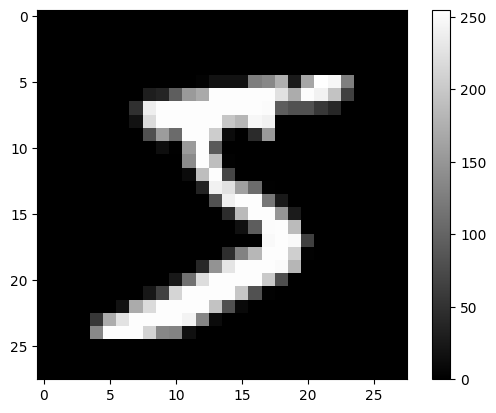

In [6]:
plt.imshow(train_dataset.data[0], cmap="gray")
plt.colorbar()

In [7]:
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
train_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
x_batch, y_batch = next(iter(train_loader))
print(x_batch.shape, y_batch.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


## What transforms.ToTensor() do?

In generally, image data saved by [H, W, C] (Height, Width, Channel) and the range of value is 0 ~ 255

Thus, ToTensor change to
- change to tensor
- [C, H, W]
- Value of data transform to 0.0 ~ 1.0

In [10]:
print("Before ToTensor:", train_dataset.data.shape)

print("After ToTensor:", x_batch.shape)

Before ToTensor: torch.Size([60000, 28, 28])
After ToTensor: torch.Size([32, 1, 28, 28])


## Model

In [11]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

        # self.fcs = nn.Sequential(
        #     nn.Linear(input_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size, num_classes)
        # )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [12]:
x_batch, _ = next(iter(train_loader))
print(x_batch.shape)
flat_images = torch.flatten(x_batch, 1)
print(flat_images.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 784])


In [13]:
model = Net(28*28, 128, 10).to(device)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [14]:
x_batch = x_batch.to(device)
print(model(x_batch).shape)

torch.Size([32, 10])


## Train Model

In [15]:
LEARNING_RATE = 1e-3
EPOCHS = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train(model, train_loader, criterion, optimizer, EPOCHS):
    model.train()
    
    for ep in range(EPOCHS):
        running_loss = 0.0
        total_samples = 0
        
        for x_batch, y_batch in tqdm(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # model inference
            y_hat = model(x_batch)
            # loss
            loss = criterion(y_hat, y_batch)
            # update
            optimizer.zero_grad() # gradient Initialize (초기화 하지 않으면 gradient가 누적됨)
            loss.backward() # backpropagation
            optimizer.step() # weight update

            # loss accumulation
            batch_size = x_batch.size(0)
            running_loss += loss.item() * batch_size
            total_samples += batch_size
        
        # 각 epoch의 평균 loss 계산
        epoch_loss = running_loss / total_samples
        print(f'Epoch [{ep+1}/{EPOCHS}], Loss: {epoch_loss:.4f}')

train(model, train_loader, criterion, optimizer, EPOCHS)

100%|██████████| 1875/1875 [00:05<00:00, 369.16it/s]


Epoch [1/10], Loss: 0.2904


100%|██████████| 1875/1875 [00:04<00:00, 452.83it/s]


Epoch [2/10], Loss: 0.1253


100%|██████████| 1875/1875 [00:04<00:00, 458.91it/s]


Epoch [3/10], Loss: 0.0859


100%|██████████| 1875/1875 [00:04<00:00, 450.42it/s]


Epoch [4/10], Loss: 0.0651


100%|██████████| 1875/1875 [00:04<00:00, 462.27it/s]


Epoch [5/10], Loss: 0.0510


100%|██████████| 1875/1875 [00:04<00:00, 462.51it/s]


Epoch [6/10], Loss: 0.0408


100%|██████████| 1875/1875 [00:04<00:00, 465.24it/s]


Epoch [7/10], Loss: 0.0320


100%|██████████| 1875/1875 [00:04<00:00, 468.52it/s]


Epoch [8/10], Loss: 0.0269


100%|██████████| 1875/1875 [00:03<00:00, 472.61it/s]


Epoch [9/10], Loss: 0.0214


100%|██████████| 1875/1875 [00:03<00:00, 471.93it/s]

Epoch [10/10], Loss: 0.0174


## Model save

In [16]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict({'fc1.weight': tensor([[ 0.0315, -0.0262,  0.0310,  ...,  0.0344, -0.0162,  0.0241],
        [ 0.0181, -0.0299,  0.0230,  ..., -0.0213,  0.0084, -0.0042],
        [-0.0162,  0.0150,  0.0003,  ...,  0.0155,  0.0046,  0.0110],
        ...,
        [-0.0070,  0.0022,  0.0340,  ..., -0.0229, -0.0272,  0.0094],
        [-0.0249,  0.0003, -0.0107,  ..., -0.0346, -0.0113, -0.0264],
        [-0.0220, -0.0219,  0.0265,  ...,  0.0218,  0.0336, -0.0083]],
       device='cuda:0'), 'fc1.bias': tensor([-0.3283, -0.0329, -0.0271,  0.2090, -0.0809, -0.0505,  0.0197, -0.0212,
         0.0852, -0.1440, -0.0373, -0.0951, -0.0032, -0.1256,  0.0297,  0.0183,
        -0.0007, -0.0152,  0.0631, -0.0649, -0.0041,  0.0552,  0.1317,  0.0136,
        -0.0253,  0.0320, -0.0056,  0.0745, -0.0144,  0.0409,  0.0364, -0.2009,
         0.0488,  0.1773, -0.1909,  0.1071, -0.1066,  0.1205,  0.1432, -0.0286,
         0.1432,  0.2029,  0.0199,  0.0313,  0.0396,  0.2770, -0.0922, -0.0534,
        -0.0467,  0.25

In [17]:
os.makedirs(os.path.dirname(CHECKPOINT_PATH), exist_ok=True)
torch.save(state_dict, CHECKPOINT_PATH)

## Model Test

In [18]:
load_model = Net(28*28, 128, 10).to(device)
load_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))

C:\Users\joy4m\AppData\Local\Temp\ipykernel_108408\2168638086.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_

<All keys matched successfully>

In [19]:
def test(model, test_loader):
    model.eval()
    with torch.no_grad():
        running_correct = 0
        for x_batch, y_batch in tqdm(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_hat = model(x_batch)
            
            pred = y_hat.argmax(dim=1, keepdim=True)
            running_correct += torch.sum(pred == y_batch.view_as(pred)).item() 

        acc = running_correct / len(test_loader.dataset) * 100
        print(f'Accuracy: {running_correct}/{len(test_loader.dataset)} {acc:.2f}%')

test(load_model, test_loader)

100%|██████████| 313/313 [00:00<00:00, 604.23it/s]

Accuracy: 9747/10000 97.47%


100%|██████████| 313/313 [00:00<00:00, 626.29it/s]


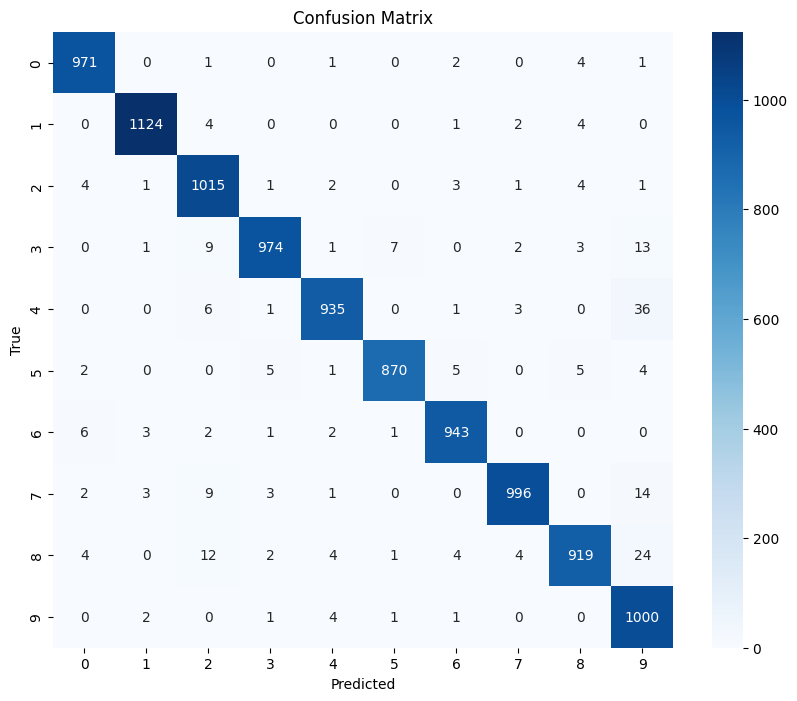

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_hat = model(x_batch)
            preds = y_hat.argmax(dim=1, keepdim=True)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(load_model, test_loader)